In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy
from matplotlib.image import imread
from IPython import display
import cv2
import os
import glob
import imageio
import PIL
import shutil

In [2]:
!gdown 1ypfb1KToy_B2RvtUlHZh8XHIiagH88Vy

Downloading...
From: https://drive.google.com/uc?id=1ypfb1KToy_B2RvtUlHZh8XHIiagH88Vy
To: /content/Dataset.zip
100% 802k/802k [00:00<00:00, 157MB/s]


In [3]:
!unzip -q Dataset.zip -d dataset

In [4]:
class1 = os.listdir('/content/dataset/Dataset/Class 1')
class2 = os.listdir('/content/dataset/Dataset/Class 2')
class3 = os.listdir('/content/dataset/Dataset/Class 3')
class4 = os.listdir('/content/dataset/Dataset/Class 4')
class5 = os.listdir('/content/dataset/Dataset/Class 5')
all_classes = [class1,class2,class3,class4,class5]

In [5]:
C1, C2, C3, C4, C5 = [],[],[],[],[]
C = [C1, C2, C3, C4, C5]
i = 0
for class_name in all_classes:
    for image_name in class_name:
        C[i].append((imread("/content/dataset/Dataset/Class {}/".format(i+1) + image_name)))
    i += 1

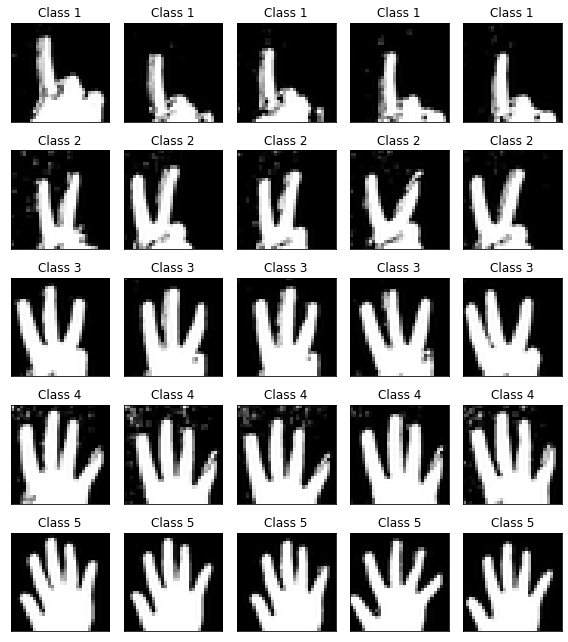

In [6]:
plt.figure(figsize=(8, 9))
cnt = 1
for i in range(5):
    for img in C[i]:
        plt.subplot(5, 5, cnt)
        plt.imshow(img,cmap='gray'), plt.xticks([]), plt.yticks([])
        plt.title('Class {}'.format(i+1))
        cnt += 1
        if cnt%5 == 1:
            break
plt.tight_layout()
plt.show()

In [7]:
images = np.reshape(C, (1005, 32, 32))

In [8]:
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 256

normalized_images = (images*255.0 - 127.5)/127.5
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# DCGAN

In [9]:
def make_disc():
    d = keras.Sequential()
    d.add(layers.Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=[32, 32, 1]))
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.3))
    d.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
    d.add(layers.LeakyReLU())
    d.add(layers.Dropout(0.3))
    d.add(layers.Flatten())
    d.add(layers.Dense(1))
    return d

discriminator = make_disc()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [10]:
def make_gen():
    g = keras.Sequential()
    g.add(layers.Dense(8*8*256, input_shape=[100]))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU(0.2))
    g.add(layers.Reshape([8, 8, 256]))
    g.add(layers.BatchNormalization())
    g.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same"))
    g.add(layers.BatchNormalization())
    g.add(layers.LeakyReLU())
    g.add(layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))
    return g

generator = make_gen()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)      

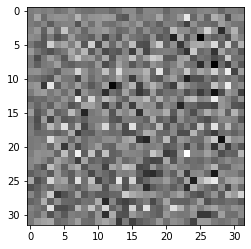

In [11]:
generator = make_gen()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [12]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00028067]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.tight_layout()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
import time 

acc_fake, acc_real = [], []
loss_disc, loss_gen = [], []

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    y_pred_real = discriminator(normalized_images, training=False)
    y_pred_real = np.where(y_pred_real>0, 1., 0.)
    acc_real.append(sum(y_pred_real == 1.)/len(y_pred_real))
    
    noise = tf.random.normal([normalized_images.shape[0], noise_dim])
    generated_images = generator(noise, training=False)
    y_pred_fake = discriminator(generated_images, training=False)
    y_pred_fake = np.where(y_pred_fake<0, 1., 0.)
    acc_fake.append(sum(y_pred_fake == 1.)/len(y_pred_fake))

    loss_disc.append(discriminator_loss(y_pred_real, y_pred_fake))
    loss_gen.append(generator_loss(y_pred_fake))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

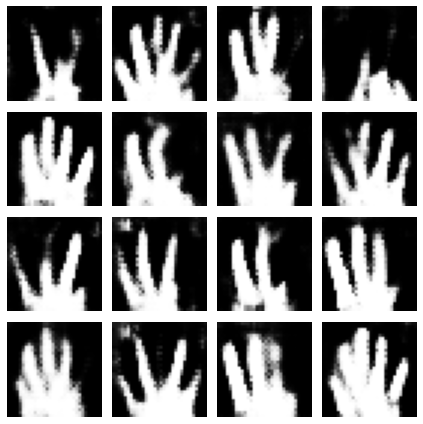

In [18]:
train(train_dataset, EPOCHS)

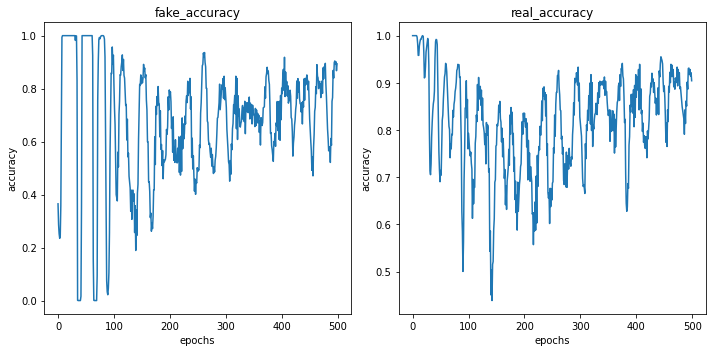

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_fake)
plt.xlabel('epochs'), plt.ylabel('accuracy')
plt.title('fake_accuracy')
plt.subplot(1, 2, 2)
plt.plot(acc_real)
plt.xlabel('epochs'), plt.ylabel('accuracy')
plt.title('real_accuracy')
plt.tight_layout()
plt.show()

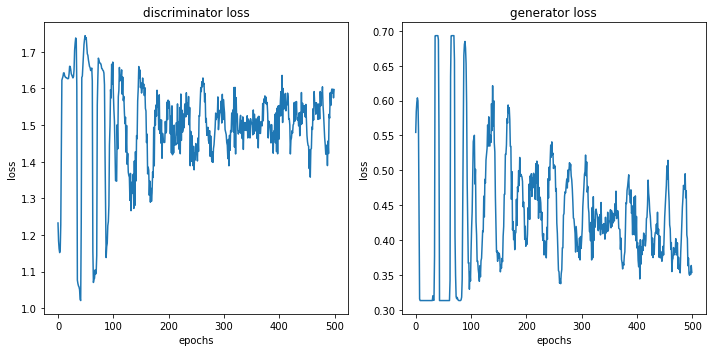

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_disc)
plt.xlabel('epochs'), plt.ylabel('loss')
plt.title('discriminator loss')
plt.subplot(1, 2, 2)
plt.plot(loss_gen)
plt.xlabel('epochs'), plt.ylabel('loss')
plt.title('generator loss')
plt.tight_layout()
plt.show()

In [ ]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

## Increasing Model Robustness

In [57]:
robust_generator = make_gen()
robust_discriminator = make_disc()

In [58]:
smoothness_index = 0.85

In [59]:
def smooth_discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output,dtype = float)*smoothness_index, real_output)
    fake_loss = cross_entropy((tf.zeros_like(fake_output,dtype = float) + (1 - smoothness_index)), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def smooth_generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output,dtype = float)*smoothness_index, fake_output)

In [60]:
@tf.function
def robust_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = robust_generator(noise, training=True) 
      real_output = robust_discriminator(images + (tf.random.normal(shape=(images.shape[0],32,32),mean=0.0,stddev=np.random.uniform(0.0, 0.1),dtype=tf.float32)), training=True)
      fake_output = robust_discriminator(generated_images, training=True)

      gen_loss = smooth_generator_loss(fake_output)
      disc_loss = smooth_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, robust_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, robust_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, robust_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, robust_discriminator.trainable_variables))

In [61]:
import time 

acc_fake, acc_real = [], []
loss_disc, loss_gen = [], []

def robust_train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      robust_train_step(image_batch)
    
    y_pred_real = robust_discriminator(normalized_images, training=False)
    y_pred_real = np.where(y_pred_real>0, 1., 0.)
    acc_real.append(sum(y_pred_real == 1.)/len(y_pred_real))
    
    noise = tf.random.normal([normalized_images.shape[0], noise_dim])
    generated_images = robust_generator(noise, training=False)
    y_pred_fake = robust_discriminator(generated_images, training=False)
    y_pred_fake = np.where(y_pred_fake<0, 1., 0.)
    acc_fake.append(sum(y_pred_fake == 1.)/len(y_pred_fake))

    loss_disc.append(discriminator_loss(y_pred_real, y_pred_fake))
    loss_gen.append(generator_loss(y_pred_fake))

    display.clear_output(wait=True)
    generate_and_save_images(robust_generator, epoch+1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(robust_generator, epochs, seed)

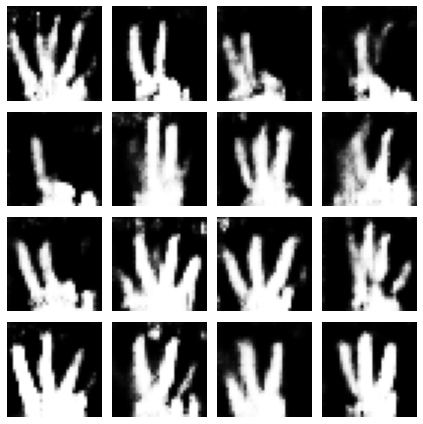

In [62]:
robust_train(train_dataset, EPOCHS)

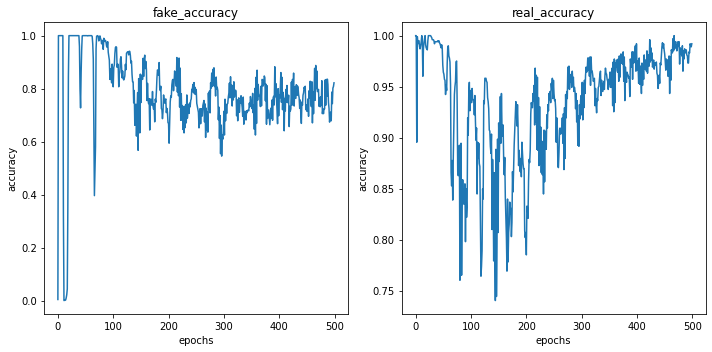

In [63]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_fake)
plt.xlabel('epochs'), plt.ylabel('accuracy')
plt.title('fake_accuracy')
plt.subplot(1, 2, 2)
plt.plot(acc_real)
plt.xlabel('epochs'), plt.ylabel('accuracy')
plt.title('real_accuracy')
plt.tight_layout()
plt.show()

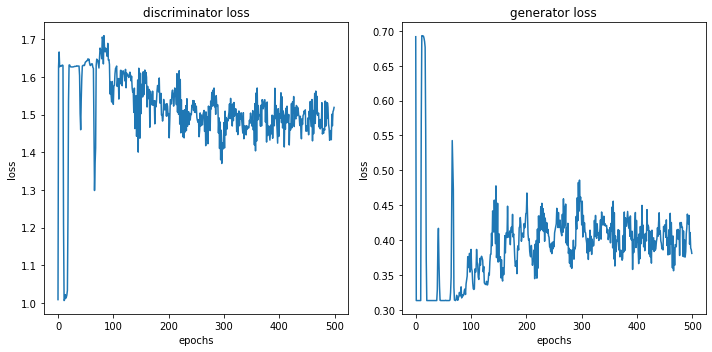

In [64]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_disc)
plt.xlabel('epochs'), plt.ylabel('loss')
plt.title('discriminator loss')
plt.subplot(1, 2, 2)
plt.plot(loss_gen)
plt.xlabel('epochs'), plt.ylabel('loss')
plt.title('generator loss')
plt.tight_layout()
plt.show()